In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Conv2D, UpSampling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import cv2
import os 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import random

In [ ]:
os.listdir('/content/drive/MyDrive/+a 프로젝트/wm-nowm') # directory with the images (root)

['.checkpoint', 'train', 'valid']

In [ ]:
# directory paths 
train_path = '/content/drive/MyDrive/+a 프로젝트/wm-nowm/train' # training directory
valid_path = '/content/drive/MyDrive/+a 프로젝트/wm-nowm/valid' # validation directory

In [ ]:
def takeFileName(filedir): # remove just file name from directory and return
    # filename = np.array(filedir.split('/'))[-1].split('.')[0] # take out the name, isolate the jpeg, then return the name
    filename = np.array(filedir.split('/'))[-1] # take out the name, then return the name
    # print(filename)
    return filename

In [ ]:
def matchFileNames(watermarkedarr, nonwatermarkedarr, dname_wm, dname_nwm):
    sortedwmarr = np.array([])
    sortednwmarr = np.array([])
    
    wmarr = list(watermarkedarr)
    nwmarr = list(nonwatermarkedarr)
    
    length = len(watermarkedarr) if len(watermarkedarr) >= len(nonwatermarkedarr) else len(nonwatermarkedarr)
    
    for pos in range(length):
        try:
            if length == len(watermarkedarr): # more images in watermarked array
                exist_nwm = nwmarr.index(wmarr[pos])
                sortedwmarr = np.append(sortedwmarr, dname_wm + watermarkedarr[pos]) # this is the iterable
                sortednwmarr = np.append(sortednwmarr, dname_nwm + nonwatermarkedarr[exist_nwm]) # this is the match
            elif length == len(nonwatermarkedarr): # more images in nonwatermarked array
                exist_wm = wmarr.index(nwmarr[pos])
                sortedwmarr = np.append(sortedwmarr, dname_wm + watermarkedarr[exist_wm]) # this is the match
                sortednwmarr = np.append(sortednwmarr, dname_nwm + nonwatermarkedarr[pos]) # this is the iterable
        except ValueError: 
            continue
    return sortedwmarr, sortednwmarr

In [ ]:
# Sort the watermarked and non watermarked images into parallel arrays so NN will use it better

train_path_watermarked_images = '/content/drive/MyDrive/+a 프로젝트/wm-nowm/train/watermark/'
train_path_nonwatermarked_images = '/content/drive/MyDrive/+a 프로젝트/wm-nowm/train/no-watermark/'

tp_watermarked = np.array([]) # array with watermarked image names
tp_nonwatermarked = np.array([]) # array with nonwatermarked image names

for root, dirs, files in os.walk(train_path_watermarked_images, topdown=True): # data length = 12510
    for file in files:
        tp_watermarked = np.append(tp_watermarked, takeFileName(file)) # append just the name of the file into array
    
for root, dirs, files in os.walk(train_path_nonwatermarked_images, topdown=True): # data length = 12477
    for file in files:
        tp_nonwatermarked = np.append(tp_nonwatermarked, takeFileName(file)) # append just the name of the file into array
        
tp_watermarked_sorted, tp_nonwatermarked_sorted = matchFileNames(tp_watermarked, tp_nonwatermarked, train_path_watermarked_images, train_path_nonwatermarked_images)


valid_path_watermarked_images = '/content/drive/MyDrive/+a 프로젝트/wm-nowm/valid/watermark/'
valid_path_nonwatermarked_images = '/content/drive/MyDrive/+a 프로젝트/wm-nowm/valid/no-watermark/'

vp_watermarked = np.array([]) # array with watermarked image names
vp_nonwatermarked = np.array([]) # array with nonwatermarked image names

for root, dirs, files in os.walk(valid_path_watermarked_images, topdown=True): # data length = 3299
    for file in files:
        vp_watermarked = np.append(vp_watermarked, takeFileName(file)) # append just the name of the file into array
    
for root, dirs, files in os.walk(valid_path_nonwatermarked_images, topdown=True): # data length = 3289
    for file in files:
        vp_nonwatermarked = np.append(vp_nonwatermarked, takeFileName(file)) # append just the name of the file into array
        
vp_watermarked_sorted, vp_nonwatermarked_sorted = matchFileNames(vp_watermarked, vp_nonwatermarked, valid_path_watermarked_images, valid_path_nonwatermarked_images)

In [ ]:
# dimension to resize to 
width = 196 # only certain dimensions work due to UpSampling (196x196 works, 148x148 works)
height = 196
dim = (width, height) # set the dimensions

def createPixelArr(files):
    data = []
    for image in files:
        try: # take each image and use imread to get the pixel values in a matrix 
            img_arr = cv2.imread(image, cv2.IMREAD_COLOR)
            resized_arr = cv2.resize(img_arr, (width, height)) # rescale the image so every image is of the same dimension
            data.append(resized_arr) # add the matrix of pixel values 
        except Exception as e:
            print(e) # some error thrown in imread or resize
    return np.array(data)

train_wms_pixVals = createPixelArr(tp_watermarked_sorted)
train_nwms_pixVals = createPixelArr(tp_nonwatermarked_sorted)

val_wms_pixVals = createPixelArr(vp_watermarked_sorted)
val_nwms_pixVals = createPixelArr(vp_nonwatermarked_sorted) # make ndarrays

In [ ]:
# TODO check if watermark and non-watermark pictures are read in correctly - (quality control) 
# make sure you create a function to make the process more efficient

In [ ]:
# TODO use sklearn to split tp_wms_pixVals, tp_nwms_pixVals into training and testing sets
# use variables names: X_train, y_train, X_test, y_test
# 80% training, 20% testing, amount of shuffling applied
X_train, X_test, y_train, y_test = train_test_split(train_wms_pixVals, train_nwms_pixVals, train_size=0.8, random_state=1) 

In [ ]:
train_wms_pixVals = 0 
train_nwms_pixVals = 0 
val_wms_pixVals = 0 
val_nwms_pixVals = 0 

In [ ]:
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Methods for data augmentation

In [ ]:
# Functions to data augment images 

def data_augmentation(inputImage): # run image through all augmentation methods
    return randomContrast(randomBrightness(inputImage)).numpy()
    # return randomCrop(randomFlip(inputImage)) # use augmentation methods without messing with colour 

def randomFlip(pic): # flips the image up and down before left and right at random
    return tf.image.random_flip_up_down(tf.image.random_flip_left_right(pic, 1), 1)

# def randomCrop(pic): # crops the image from a randomly defined width and height, that are under the intial image width and height
#     return tf.image.random_crop(pic, size=[random.randint(75,width), random.randint(75,height), 3], seed=None)

def randomBrightness(pic): # makes the image a random brightness from 1% to 20%
    return tf.image.random_brightness(pic, random.uniform(0.01, 0.2), 1)

def randomContrast(pic): # contrasts the image from 5% to 50%
    return tf.image.random_contrast(pic, 0.2, 0.7, 1)

In [ ]:
# Output Tensorflow data augmented images
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    augmented_image = data_augmentation(X_train[random.randint(1, len(X_train))]) # send 25 images into data augmentation
    plt.imshow(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB)) # not using cv2 as it messed up the code
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#apply data augmentation to the X_train and y_train

data_augmented_X = [] 
data_augmented_y = []

for image in X_train:
    data_augmented_X.append(data_augmentation(image))
    
for image in y_train:
    data_augmented_y.append(data_augmentation(image))

In [ ]:
# Data Augmentation Pictures

In [ ]:
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(data_augmented_X[i], cv2.COLOR_BGR2RGB))
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(data_augmented_y[i], cv2.COLOR_BGR2RGB))
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Combine the augmented images with the training sets
X_train = np.append(X_train, data_augmented_X, axis=0)
y_train = np.append(y_train, data_augmented_y, axis=0)

In [ ]:
# Normalizet the values between 0 and 1
X_train = X_train / 255
y_train = y_train / 255
X_test = X_test / 255
y_test = y_test / 255

In [ ]:
# Base convolutional autoencoder

In [ ]:
# base model for removing 

def create_model(img_x, img_y):
    x = Input(shape=(img_x, img_y, 3))
    
    # Think this process as function composition in algebra 
    
    # Encoder - compresses the input into a latent representation
    e_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    pool1 = MaxPooling2D((2, 2), padding='same')(e_conv1)
    batchnorm_1 = BatchNormalization()(pool1)
    
    e_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(batchnorm_1)
    pool2 = MaxPooling2D((2, 2), padding='same')(e_conv2)
    batchnorm_2 = BatchNormalization()(pool2)
    
    e_conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')(batchnorm_2)
    h = MaxPooling2D((2, 2), padding='same')(e_conv3)
    
    # Decoder - reconstructs the input from a latent representation 
    d_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
    up1 = UpSampling2D((2, 2))(d_conv1)
    
    d_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2, 2))(d_conv2)
    
    d_conv3 = Conv2D(16, (3, 3), activation='relu')(up2)
    up3 = UpSampling2D((2, 2))(d_conv3)
    
    r = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)
    
    model = Model(x, r)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
    return model

In [ ]:
watermark_auto_encoder = create_model(width, height)
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
history = watermark_auto_encoder.fit(X_train, y_train, batch_size=20, epochs=100, callbacks=[early_stop])

Epoch 1/100
140/140 [==============================] - 413s 3s/step - loss: 0.0187
Epoch 2/100
140/140 [==============================] - 405s 3s/step - loss: 0.0142
Epoch 3/100
140/140 [==============================] - 410s 3s/step - loss: 0.0134
Epoch 4/100
140/140 [==============================] - 403s 3s/step - loss: 0.0127
Epoch 5/100
140/140 [==============================] - 406s 3s/step - loss: 0.0125
Epoch 6/100
140/140 [==============================] - 404s 3s/step - loss: 0.0125
Epoch 7/100
140/140 [==============================] - 405s 3s/step - loss: 0.0120
Epoch 8/100
140/140 [==============================] - 404s 3s/step - loss: 0.0121
Epoch 9/100
140/140 [==============================] - 406s 3s/step - loss: 0.0117
Epoch 10/100
140/140 [==============================] - 405s 3s/step - loss: 0.0119
Epoch 11/100
140/140 [==============================] - 404s 3s/step - loss: 0.0115
Epoch 12/100
140/140 [==============================] - 403s 3s/step - loss: 0.0112
E

In [ ]:
# Results of the convolutional autoencoder model

In [ ]:
result = watermark_auto_encoder.predict(X_test)
watermark_auto_encoder.evaluate(X_test, result)

11/11 [==============================] - 12s 1s/step - loss: 0.0000e+00


0.0

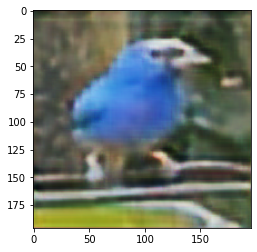

In [ ]:
plt.imshow(cv2.cvtColor(result[5], cv2.COLOR_BGR2RGB))

In [ ]:
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(X_test[i].astype('float32'), cv2.COLOR_BGR2RGB))
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(result[i], cv2.COLOR_BGR2RGB))
plt.show()

Output hidden; open in https://colab.research.google.com to view.